In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
#preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class MusicFeatureEngineering(BaseEstimator, TransformerMixin):
    def _init_(self):
        self.min_date_ = None

    def fit(self, X, y=None):
        dates = pd.to_datetime(X['release_date'], format='mixed')
        self.min_date_ = dates.min()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['release_date'] = pd.to_datetime(X_copy['release_date'], format='mixed')
        X_copy['days_since_1900'] = (X_copy['release_date'] - self.min_date_).dt.days
        X_copy['ratio'] =X_copy['energy']/(X_copy['acousticness'] + 1e-6)
        if 'explicit' in X_copy.columns:
            X_copy['explicit'] = X_copy['explicit'].astype(int)

        cols_to_drop = ['release_date']
        X_copy = X_copy.drop(columns=[c for c in cols_to_drop if c in X_copy.columns])
        
        return X_copy

df_train= pd.read_csv("../data/raw/spotify_dataset_train.csv")
df_test= pd.read_csv("../data/raw/spotify_dataset_test.csv")

X = df_train.drop(columns=['genre'])
y = df_train['genre']

pipeline_X = Pipeline([
    ('feature_eng', MusicFeatureEngineering())])

label_encoder_y = LabelEncoder()

X_processed = pipeline_X.fit_transform(X)
y_encoded = label_encoder_y.fit_transform(y)

X_processed_test = pipeline_X.fit_transform(X)

## Dimension reduction


In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
lda = LinearDiscriminantAnalysis(n_components=min(1, len(np.unique(y_encoded))-1))  
X_lda = lda.fit_transform(X_scaled, y_encoded)

In [5]:
# Coef
coeficientes = lda.coef_

# Nombres de las características originales
nombres_caracteristicas = X_processed.columns


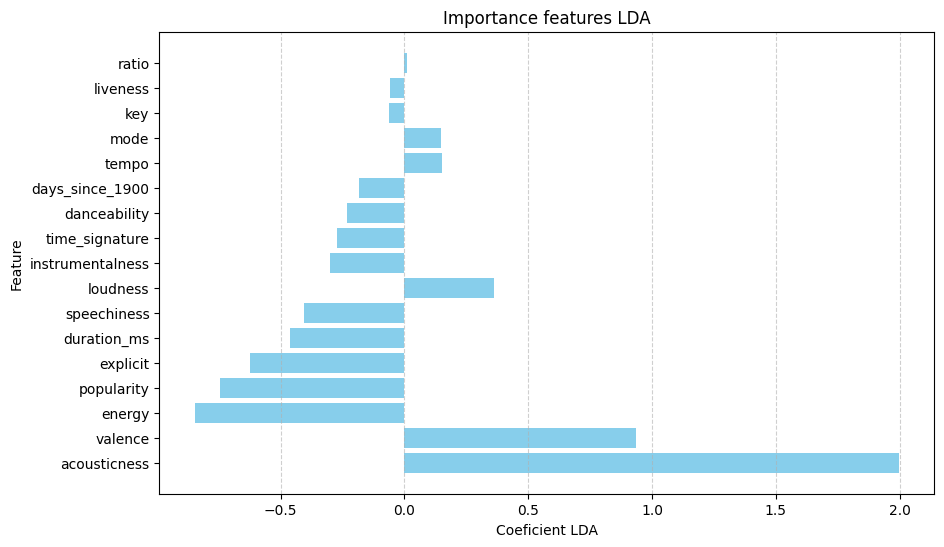

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Para el primer componente LDA
coef_lda1 = coeficientes[0]

# Ordenar características por importancia absoluta
indices_ordenados = np.argsort(np.abs(coef_lda1))[::-1]
caracteristicas_ordenadas = nombres_caracteristicas[indices_ordenados]
valores_coeficientes = coef_lda1[indices_ordenados]

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(caracteristicas_ordenadas, valores_coeficientes, color='skyblue')
plt.title('Importance features LDA')
plt.xlabel('Coeficient LDA')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


## Classification

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_lda, y_encoded, cv=5)
print(f"Accuracy promedio: {scores.mean():.2f}")


Accuracy promedio: 0.18


## Resampling Values

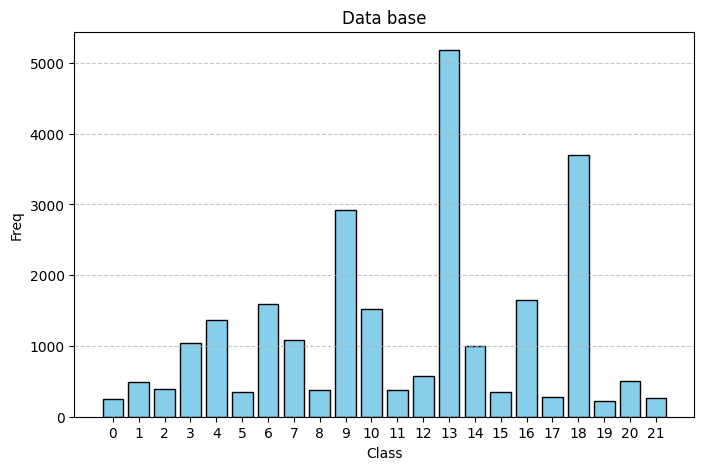

In [8]:
unique_classes, counts = np.unique(y_encoded, return_counts=True)

sorted_indices = np.argsort(unique_classes)
unique_classes_sorted = unique_classes[sorted_indices]
counts_sorted = counts[sorted_indices]

plt.figure(figsize=(8, 5))
plt.bar(unique_classes_sorted, counts_sorted, color='skyblue', edgecolor='black')
plt.title('Data base')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.xticks(unique_classes_sorted)  # Asegura que las clases estén en orden en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### SMOTE

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_processed, y_encoded)


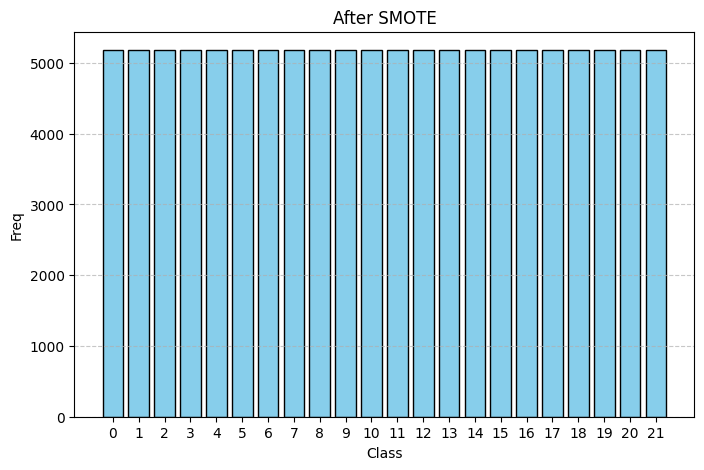

In [11]:
unique_classes, counts = np.unique(y_resampled, return_counts=True)

sorted_indices = np.argsort(unique_classes)
unique_classes_sorted = unique_classes[sorted_indices]
counts_sorted = counts[sorted_indices]

plt.figure(figsize=(8, 5))
plt.bar(unique_classes_sorted, counts_sorted, color='skyblue', edgecolor='black')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.xticks(unique_classes_sorted)  # Asegura que las clases estén en orden en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## LDA after SMOTE

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
lda = LinearDiscriminantAnalysis(n_components=min(3, len(np.unique(y_resampled))-1))  # Ejemplo: 3 componentes
X_lda = lda.fit_transform(X_scaled, y_resampled)
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_lda, y_resampled, cv=5)
print(f"Accuracy promedio: {scores.mean():.2f}")

Accuracy promedio: 0.42


In [13]:
X_resampled.shape


(113982, 17)

## LGBL

In [15]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

X_train, X_test, Y_train, Y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)


# Crear el modelo
lgbm = LGBMClassifier(random_state=42)

# Entrenar
lgbm.fit(X_train, Y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3179
[LightGBM] [Info] Number of data points in the train set: 79787, number of used features: 17
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.091230
[LightGBM] [Info] Start training from score -3.091230
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.091230
[LightGBM] [Info] Start training from score -3.091230
[LightGBM] [Info] Start training from score -3.090955
[LightGBM] [Info] Start training from score -3.090955
[LightGBM

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

# Predecir
Y_pred_lgbm = lgbm.predict(X_test)

# Evaluar
print("LGBMClassifier:")
print("Accuracy:", accuracy_score(Y_test, Y_pred_lgbm))

# Validación cruzada para F1-score (macro)
f1_cv_micro = cross_val_score(lgbm, X_resampled, y_resampled, cv=5, scoring='f1_micro')
print("F1 (micro): ",f1_cv_micro.mean())



LGBMClassifier:
Accuracy: 0.7467466003801725
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3178
[LightGBM] [Info] Number of data points in the train set: 91185, number of used features: 17
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.091229
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] Start training from score -3.090988
[LightGBM] [Info] 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Definir la grilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
}

# Crear el grid search
grid_search = GridSearchCV(
    LGBMClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1_macro',  # Usa 'accuracy' si prefieres
    verbose=1
)

# Entrenar
grid_search.fit(X_train, Y_train)

# Mejor modelo
best_lgbm = grid_search.best_estimator_
print("Mejores parámetros:", grid_search.best_params_)

# Evaluar el mejor modelo
Y_pred_best = best_lgbm.predict(X_test)
print("\nMejor LGBMClassifier:")
print(classification_report(Y_test, Y_pred_best))
print("Accuracy:", accuracy_score(Y_test, Y_pred_best))
